<a href="https://colab.research.google.com/github/noircir/TensorFlow-Examples/blob/master/TF1_CNN_01_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

In [0]:
%tensorflow_version 1.x

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets('/content/drive/My Drive/Colab Notebooks/TF 1.0/MNIST_data2/',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/My Drive/Colab Notebooks/TF 1.0/MNIST_data2/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/My Drive/Colab Notebooks/TF 1.0/MNIST_data2/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /content/drive/My Drive/Colab Notebooks/TF 1.0/MNIST_data2/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/Colab Notebooks/TF 1.0/MNIST_data2/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
# difference between truncated normal and normal distributions
# https://bit.ly/2rukskm

import matplotlib.pyplot as plt

n = 500000
A = tf.truncated_normal(shape=(n,)) # shape: A 1-D integer Tensor or Python array. The shape of the output tensor.
B = tf.random_normal(shape=(n,))
with tf.Session() as sess:
    a, b = sess.run([A, B])

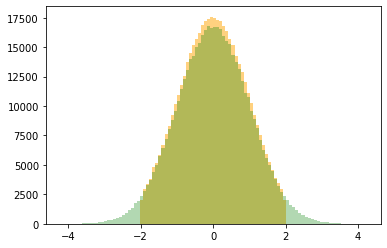

In [7]:
plt.hist(a, bins=100, range=(-4.2, 4.2), color='orange', alpha=0.5);
plt.hist(b, bins=100, range=(-4.2, 4.2), color='green', alpha=0.3);

In [0]:
# HELPER

# INIT WEIGHTS
# the shape of weights depends on the shape of tensor

def init_weights(shape):
  init_random_dist = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(init_random_dist)

# INIT BIAS
# the shape of biases depends on the shape of tensor

def init_bias(shape):
  init_bias_vals = tf.constant(value=0.1, shape=shape)
  return tf.Variable(init_bias_vals)

# CONV2D

def conv2d(x,W):
  # x --> [batch, H, W, Channels]
  # W --> [filter H, filter W, Channels IN, Channels OUT]

  return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME') # 'SAME" means padding of zeros

# POOLING
# Pooling the max digit that the filter calculates (sharpening or blurring)

def max_pool_2by2(x):
  # x --> [batch,h,w,c]
  # we are only concerned with individual images height and width: 2x2
  return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')



In [0]:
# CONVOLUTIONAL LAYER

def convolutional_layer(input_x, shape):
  W = init_weights(shape)
  b = init_bias([shape[3]])
  # ReLu is applied to the result of convolution
  return tf.nn.relu(conv2d(input_x, W)+b)

In [0]:
# NORMAL FULLY CONNECTED LAYER

def normal_full_layer(input_layer, size):
  input_size = int(input_layer.get_shape()[1])
  W = init_weights([input_size, size])
  b = init_bias([size])
  return tf.matmul(input_layer,W) + b

In [0]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, shape=[None,784])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [0]:
# LAYERS

x_image = tf.reshape(x, [-1,28,28,1])

In [0]:
# computing 32 features for each 5x5 patch, 1 is the number of channels, 32 is the number of features we are computing
convo_1 = convolutional_layer(x_image, shape=[5,5,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [0]:
convo_2 = convolutional_layer(convo_1_pooling, shape = [5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [0]:
# Why 7 by 7 image? Because we did 2 pooling layers, so (28/2)/2 = 7
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling, [-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [0]:
# DROPOUT

# NOTE THE PLACEHOLDER HERE!
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,rate=1-hold_prob)

In [0]:
y_pred = normal_full_layer(full_one_dropout,10)

In [0]:
# LOSS FUNCTION

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [0]:
# OPTIMIZER

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

In [0]:
# INITIALIZE VARIABLES

init = tf.global_variables_initializer()

In [21]:
steps = 5000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = mnist.train.next_batch(50)
        
        # hold_prob:0.5 means each neuron has 50% chance of being held (randomly)
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5}) 
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')

            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1)) # list of booleans, so we need to cast into float32

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1509


Currently on step 100
Accuracy is:
0.8402


Currently on step 200
Accuracy is:
0.9052


Currently on step 300
Accuracy is:
0.9209


Currently on step 400
Accuracy is:
0.9386


Currently on step 500
Accuracy is:
0.9464


Currently on step 600
Accuracy is:
0.9503


Currently on step 700
Accuracy is:
0.9564


Currently on step 800
Accuracy is:
0.96


Currently on step 900
Accuracy is:
0.9627


Currently on step 1000
Accuracy is:
0.9651


Currently on step 1100
Accuracy is:
0.9673


Currently on step 1200
Accuracy is:
0.9675


Currently on step 1300
Accuracy is:
0.9686


Currently on step 1400
Accuracy is:
0.969


Currently on step 1500
Accuracy is:
0.9716


Currently on step 1600
Accuracy is:
0.9727


Currently on step 1700
Accuracy is:
0.9745


Currently on step 1800
Accuracy is:
0.9757


Currently on step 1900
Accuracy is:
0.9777


Currently on step 2000
Accuracy is:
0.977


Currently on step 2100
Accuracy is:
0.9785


Currently on step 2200
Acc